In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('D:\dev\project\Football-Match-Prediction\data\processed\df_merged.csv')

In [9]:
data.describe()

,HomeTeam_GF_WeightedAvg,HomeTeam_GA_WeightedAvg,HomeTeam_xG_WeightedAvg,HomeTeam_xGA_WeightedAvg,HomeTeam_Standard__SoT_WeightedAvg,HomeTeam_Standard__SoT%_WeightedAvg,HomeTeam_Standard__G/Sh_WeightedAvg,HomeTeam_Standard__G/SoT_WeightedAvg,HomeTeam_Expected__npxG/Sh_WeightedAvg,HomeTeam_Expected__G-xG_WeightedAvg,...,AwayTeam_Carries__CPA_WeightedAvg,AwayTeam_Points_WeightedAvg,AwayTeam_GD_WeightedAvg,AwayTeam_GF,H2H_Total_Matches,H2H_Home_Wins,H2H_Away_Wins,H2H_Draws,H2H_Home_Goals,H2H_Away_Goals
count,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,...,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000
mean,1.314806,1.302321,1.299659,1.319158,3.877018,34.176972,0.106136,0.296327,0.104470,-0.022687,...,4.198011,1.394893,0.021735,1.104706,8.577891,1.530099,1.604159,2.310106,10.945275,11.278366
std,0.416938,0.341934,0.292174,0.230036,0.952319,4.479798,0.027549,0.056247,0.014141,0.207799,...,1.545972,0.423884,0.624816,1.088250,7.132393,1.823685,1.848408,2.819795,11.060052,11.265129
min,0.000000,0.000000,0.000000,0.466667,0.000000,0.000000,0.000000,0.000000,0.020000,-1.471429,...,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.039306,1.132489,1.111055,1.160914,3.269812,31.689382,0.088817,0.268344,0.097736,-0.136268,...,3.120724,1.133428,-0.362731,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,1.287094,1.309508,1.248820,1.298628,3.707219,33.688070,0.103638,0.299713,0.103810,-0.018416,...,3.829882,1.320256,-0.059545,1.000000,8.000000,1.000000,1.000000,2.000000,8.000000,8.000000
75%,1.450000,1.494792,1.395567,1.436750,4.181538,36.429809,0.122672,0.330807,0.112193,0.073744,...,4.860294,1.566532,0.254810,2.000000,14.000000,2.000000,2.000000,4.000000,16.000000,16.000000
max,4.000000,4.833333,2.900000,3.350000,8.000000,80.000000,0.279697,0.676667,0.223333,1.483333,...,15.000000,3.000000,3.500000,7.000000,28.000000,11.000000,12.000000,18.000000,76.000000,84.000000


In [13]:
# Ensure 'Time' is in datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Split the data into training and validation sets
train = data[data['Time'] <= '2023-08']
valid = data[data['Time'] > '2023-08']

In [14]:
from sklearn.preprocessing import StandardScaler


y_train = train['HomeTeam_Result'].map({'W' : 2, 'D' : 1, 'L' : 0})
y_valid = valid['HomeTeam_Result'].map({'W' : 2, 'D' : 1, 'L' : 0})
X_train = train.drop(columns=['Time', 'HomeTeam_Result', 'HomeTeam_GF', 'AwayTeam_GF'])
X_valid = valid.drop(columns=['Time', 'HomeTeam_Result', 'HomeTeam_GF', 'AwayTeam_GF'])

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [16]:
X_valid.head()

,HomeTeam_GF_WeightedAvg,HomeTeam_GA_WeightedAvg,HomeTeam_xG_WeightedAvg,HomeTeam_xGA_WeightedAvg,HomeTeam_Standard__SoT_WeightedAvg,HomeTeam_Standard__SoT%_WeightedAvg,HomeTeam_Standard__G/Sh_WeightedAvg,HomeTeam_Standard__G/SoT_WeightedAvg,HomeTeam_Expected__npxG/Sh_WeightedAvg,HomeTeam_Expected__G-xG_WeightedAvg,...,AwayTeam_Touches__Att Pen_WeightedAvg,AwayTeam_Carries__CPA_WeightedAvg,AwayTeam_Points_WeightedAvg,AwayTeam_GD_WeightedAvg,H2H_Total_Matches,H2H_Home_Wins,H2H_Away_Wins,H2H_Draws,H2H_Home_Goals,H2H_Away_Goals
2261,1.392713,1.736842,1.251147,1.650877,4.071525,36.842510,0.123104,0.371856,0.099460,0.141565,...,18.684660,3.840756,0.962663,-0.617184,4,1,1,0,6.0,6.0
2262,1.396986,1.146874,1.392960,1.132006,4.021368,32.948605,0.104305,0.320204,0.101579,-0.026563,...,18.280477,3.710751,1.404858,0.060954,24,5,3,8,24.0,24.0
2263,1.328610,1.142375,1.395367,1.110459,3.793522,32.971410,0.104129,0.318385,0.111345,-0.126811,...,18.288349,3.366622,1.155196,-0.246964,12,2,0,8,26.0,12.0
2264,0.543860,1.781377,0.968961,1.881107,2.684211,23.375709,0.027692,0.133103,0.072146,-0.425101,...,16.489879,3.710301,1.082771,-0.508322,0,0,0,0,0.0,0.0
2265,1.116059,1.176563,1.233198,1.161426,3.665767,33.158480,0.086345,0.245586,0.099622,-0.164372,...,29.275529,8.072650,2.072425,1.024741,24,0,7,10,10.0,32.0


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# from sklearn.model_selection import cross_val_score

# models = {
#     'Logistic Regression': LogisticRegression(solver='liblinear'),
#     'Random Forest': RandomForestClassifier(),
#     'SVC': SVC()
# }

# for name, model in models.items():
#     scores = cross_val_score(model, X, y, cv=10)
#     print(f"{name} Cross-Validation Accuracy: {scores.mean():.2f} (+/- {scores.std():.2f})")

In [ ]:
# One-hot encode the team names
X_train = pd.get_dummies(X_train, columns=['HomeTeam', 'AwayTeam'])
X_valid = pd.get_dummies(X_valid, columns=['HomeTeam', 'AwayTeam'])
# Align the columns of X_valid to match X_train
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)

KeyError: "None of [Index(['HomeTeam', 'AwayTeam'], dtype='object')] are in the [columns]"

In [22]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       133
           1       0.31      0.13      0.18       135
           2       0.56      0.77      0.65       212

    accuracy                           0.51       480
   macro avg       0.45      0.46      0.44       480
weighted avg       0.47      0.51      0.47       480



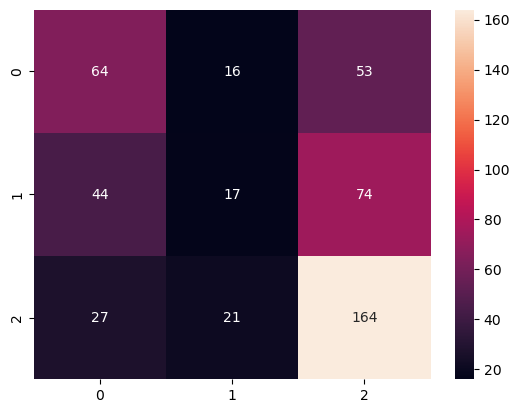

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

sns.heatmap(confusion_matrix(y_valid, y_pred), annot = True, fmt='d')
print(classification_report(y_valid, y_pred))